# Imports and data
The libraries used in this notebook are available by calling `pipenv install --dev` in the top-level of the repository.
Once installed, you can call `pipenv run jupyter-notebook` to open your Jupyter workspace, navigate to `examples/swifter_speed_comparison.ipynb` and run the cells.

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import swifter
import perfplot
import matplotlib.pyplot as plt
import psutil

/Users/jcarpenter/.local/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
ncores = psutil.cpu_count()
npartitions = ncores*2

These data (~71 million rows) were taken from https://www.kaggle.com/benhamner/sf-bay-area-bike-share/data.
In order to run the speed comparisons in this notebook yourself, you will need to download the data from that location, and unzip the file into the the `examples` directory.

In [3]:
data = pd.read_feather("../../swifter_data/data/status")

In [5]:
data = pd.read_csv('status.csv')
data['date'] = pd.to_datetime(data['time'])

In [6]:
print(data.shape)
data.head()

(71984434, 5)


,station_id,bikes_available,docks_available,time,date
0,2,2,25,2013/08/29 12:06:01,2013-08-29 12:06:01
1,2,2,25,2013/08/29 12:07:01,2013-08-29 12:07:01
2,2,2,25,2013/08/29 12:08:01,2013-08-29 12:08:01
3,2,2,25,2013/08/29 12:09:01,2013-08-29 12:09:01
4,2,2,25,2013/08/29 12:10:01,2013-08-29 12:10:01


# Function Definitions

## Vectorized function
This function doesn't contain any control-flow logic e.g. if/else and is simply a numeric computation.


As such, we can call it in a vectorized fashion e.g. `bikes_proportion(df["bikes_available"], max_x=np.max(data["bikes_available"]))`

In [5]:
def bikes_proportion(x, max_x):
    return x * 1.0 / max_x

## Non-vectorized function
This function does contain a control-flow logic e.g. if/else and therefore cannot be called in a vectorized sense.

As such, we can't include the vectorized comparison in our perfplot.

In [6]:
def is_morning(datetime):
    if (datetime.hour >= 6) and (datetime.hour < 12):
        return True
    else:
        return False

## Non-vectorized string functions
This function performs an operation on a string column, and therefore leverages modin dataframes.

In [4]:
def display_information(row):
    return f"Station ID {row['station_id']} had {row['bikes_available']} bikes available at {row['time']}. This is {np.where(row['bikes_available'] > row['docks_available'], 'more', 'less')} than the number of docks available ({row['docks_available']})."

# Perfplot
[Perfplot](https://github.com/unutbu/perfplot) is a library for performing speed comparisons of various functions.

Here we use perfplot to compare pandas apply, dask apply, vectorized functions, and swifter apply.

## Vectorized function speed comparison

In [7]:
vectorized_comparison = perfplot.bench(
    setup=lambda n: data.loc[:n, 'bikes_available'],
    kernels=[
        lambda df: df.apply(bikes_proportion, max_x=np.max(data['bikes_available'])),
        lambda df: dd.from_pandas(df, npartitions=npartitions).map_partitions(bikes_proportion, max_x=np.max(data['bikes_available']), meta=('f8')).compute(scheduler='threads'),
        lambda df: bikes_proportion(df, max_x=np.max(data['bikes_available'])),
        lambda df: df.swifter.progress_bar(False).apply(bikes_proportion, max_x=np.max(data['bikes_available']))
    ],
    labels=['Pandas Apply', 'Dask Apply', 'Vectorized Function', 'Swifter Apply'],
    n_range=[2**k for k in range(0, 28, 2)],
    xlabel='n_rows'
)

100%|██████████| 14/14 [27:10<00:00, 116.48s/it]


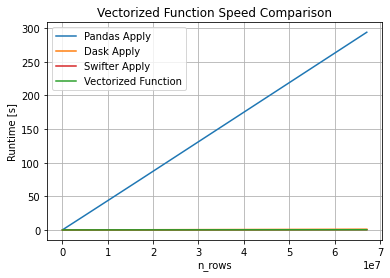

In [8]:
vectorized_comparison.title = "Vectorized Function Speed Comparison"
vectorized_comparison.xlabel = "n_rows"
vectorized_comparison.plot(logx=False, logy=False)

Text(0, 0.5, 'Runtime [log10(s)]')

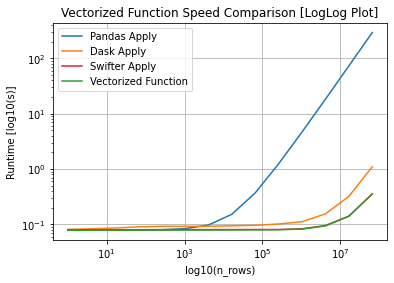

In [9]:
vectorized_comparison.xlabel = 'log10(n_rows)'
vectorized_comparison.title = 'Vectorized Function Speed Comparison [LogLog Plot]'
vectorized_comparison.plot(logx=True, logy=True, time_unit='s')
plt.ylabel("Runtime [log10(s)]")

## Non-vectorized function speed comparison

In [13]:
nonvectorized_comparison = perfplot.bench(
    setup=lambda n: data.loc[:n, 'date'],
    kernels=[
        lambda df: df.apply(is_morning),
        lambda df: dd.from_pandas(df, npartitions=npartitions).apply(is_morning, meta=(bool)).compute(scheduler='processes'),
        lambda df: df.swifter.progress_bar(False).apply(is_morning)
    ],
    labels=['Pandas Apply', 'Dask Apply', 'Swifter Apply'],
    n_range=[2**k for k in range(0, 28, 2)],
    xlabel='n_rows'
)

100%|██████████| 14/14 [37:08<00:00, 159.20s/it]


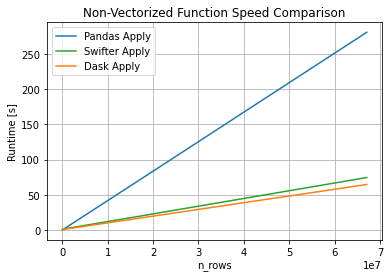

In [14]:
nonvectorized_comparison.title = "Non-Vectorized Function Speed Comparison"
nonvectorized_comparison.xlabel = "n_rows"
nonvectorized_comparison.plot(logx=False, logy=False)

Text(0, 0.5, 'Runtime [log10(s)]')

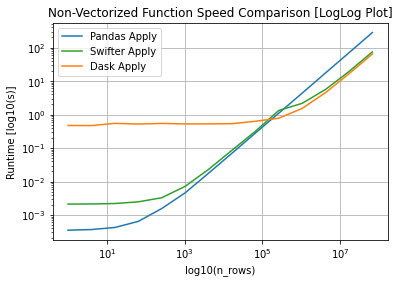

In [15]:
nonvectorized_comparison.xlabel = 'log10(n_rows)'
nonvectorized_comparison.title = 'Non-Vectorized Function Speed Comparison [LogLog Plot]'
nonvectorized_comparison.plot(logx=True, logy=True, time_unit='s')
plt.ylabel("Runtime [log10(s)]")

## Non-vectorized string function speed comparison

In [9]:
def clean_text(text_row):
    text = text_row["text"].strip()
    text = text.replace(' ', '_')
    return text

In [4]:
N_rows = 70000000
df_data = pd.DataFrame([["i want to break free"]] * N_rows, columns=["text"])

In [13]:
nonvectorized_string_comparison = perfplot.bench(
    setup=lambda n: data.loc[:n],
    kernels=[
        lambda df: df.apply(display_information, axis=1),
        lambda df: dd.from_pandas(df, npartitions=npartitions).apply(display_information, axis=1, meta=(str)).compute(scheduler='processes'),
        lambda df: df.swifter.progress_bar(False).allow_dask_on_strings(True).apply(display_information, axis=1),
        lambda df: df.swifter.progress_bar(False).allow_dask_on_strings(False).apply(display_information, axis=1),
    ],
    labels=['Pandas Apply', 'Dask Apply', 'Swifter Dask Apply', 'Swifter Modin Apply'],
    n_range=[2**k for k in range(0, 28, 2)],
    xlabel='n_rows',
    equality_check=lambda left, right: left.equals(right)
)

  0%|          | 0/4 [00:00<?, ?it/s]

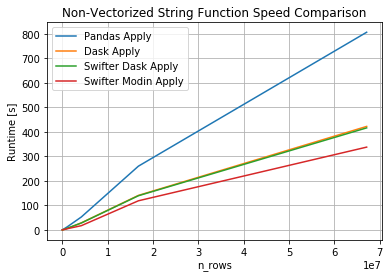

In [8]:
fig = plt.figure()
nonvectorized_string_comparison.title = "Non-Vectorized String Function Speed Comparison"
nonvectorized_string_comparison.xlabel = "n_rows"
nonvectorized_string_comparison.plot(logx=False, logy=False)
plt.savefig("nonvectorized_string_axis1_speed_comparison.png")

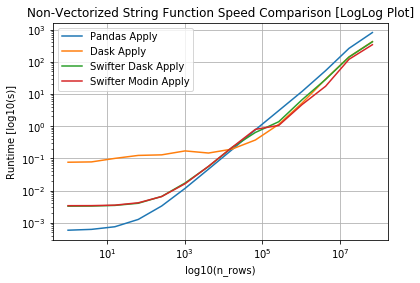

In [9]:
fig = plt.figure()
nonvectorized_string_comparison.xlabel = 'log10(n_rows)'
nonvectorized_string_comparison.title = 'Non-Vectorized String Function Speed Comparison [LogLog Plot]'
nonvectorized_string_comparison.plot(logx=True, logy=True, time_unit='s')
plt.ylabel("Runtime [log10(s)]")
plt.savefig("nonvectorized_string_axis1_speed_comparison_loglog.png")